In [1]:
import requests as rq
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from TCGA_files import *
#from ensembleAPI import geneinfo, genesinfo
from sklearn import metrics
from hsbmpy import *
import os

In [ ]:
import importlib, hsbmpy
importlib.reload(hsbmpy)
from hsbmpy import *

## query many

In [2]:
level = 1
#setup='highlyvariable_colonrectal'
#setup = 'oversigma_10tissue'
#label = 'disease_type'
label='primary_site'
#labels = ['primary_site', 'disease_type', 'disease_tissue']
#labels=['RPPA','PAM50', 'disease_type','primary_diagnosis']
#labels = ['primary_site', 'secondary_site']
algorithm = 'wgcna'
#labels = ['primary_site', 'secondary_site', 'status']
#labels=['RPPA Clusters']
directory = "/home/fvalle/phd/datasets/gtex/log/3000_random-5000hvg/"
L=get_max_available_L(directory, algorithm)
df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,L), header=[0])
df_clusters.head()

,Cluster 1,Cluster 2,Cluster 3
0,GTEX-16NPV-0011-R8a-SM-7EPH8,GTEX-T6MN-1226-SM-3NMA5,GTEX-147JS-0126-SM-5S2TW
1,GTEX-U8T8-0126-SM-3DB94,GTEX-Y5LM-0426-SM-4VBRO,GTEX-1C64N-2826-SM-7IGP5
2,GTEX-12ZZW-0011-R5a-SM-5DUVN,GTEX-X4EO-1126-SM-4QARQ,GTEX-ZAB4-0126-SM-5CVMG
3,GTEX-11TT1-1926-SM-5PNYN,GTEX-RWSA-1426-SM-47JXA,GTEX-WZTO-0326-SM-4PQYZ
4,GTEX-Q2AG-0626-SM-2S1PV,GTEX-18465-1626-SM-7LG6N,GTEX-S7SE-0326-SM-4AT5Q


In [5]:
df_file = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t')
df_file.set_index('SAMPID', inplace=True)
df_file.dropna(how='all', axis=0).to_csv("%s/files.dat"%directory, index=True, header=True)

In [6]:
df_files = pd.read_csv("%s/files.dat"%directory, index_col=[0], header=[0]).dropna(axis=1, how='all').dropna(axis=0, how='all')
#df_files.insert(2,'disease_tissue',["%s[%s]"%(df_files.at[s,'primary_site'],df_files.at[s,'disease_type']) for s in df_files.index])
labels=df_files.columns
#df_files.groupby(['primary_site','disease_type']).count()
labels

Index(['SMATSSCR', 'SMCENTER', 'SMPTHNTS', 'SMRIN', 'SMTS', 'SMTSD', 'SMUBRID',
       'SMTSISCH', 'SMTSPAX', 'SMNABTCH', 'SMNABTCHT', 'SMNABTCHD', 'SMGEBTCH',
       'SMGEBTCHD', 'SMGEBTCHT', 'SMAFRZE', 'SMGTC', 'SME2MPRT', 'SMCHMPRS',
       'SMNTRART', 'SMMAPRT', 'SMEXNCRT', 'SMGNSDTC', 'SMUNMPRT', 'SMRDLGTH',
       'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT', 'SMRRNANM',
       'SMRDTTL', 'SMVQCFL', 'SMTRSCPT', 'SMMPPDPR', 'SMUNPDRD', 'SMNTRNRT',
       'SMMPUNRT', 'SMEXPEFF', 'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG',
       'SME2SNSE', 'SMMFLGTH', 'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE',
       'SME1PCTS', 'SMRRNART', 'SME1MPRT', 'SMDPMPRT', 'SME2PCTS'],
      dtype='object')

In [7]:
labels = ['cases.0.diagnoses.0.prior_malignancy',
       'cases.0.diagnoses.0.tumor_grade', 'cases.0.project.primary_site',
       'cases.0.project.disease_type', 'cases.0.diagnoses.0.tumor_stage',
       'cases.0.diagnoses.0.progression_or_recurrence']
labels=['primary_site', 'disease_type']
labels=['SMTS']

In [ ]:
for normalise in [True, False]:
    for label in labels:
        for level in np.arange(L+1)[::-1]:
            if level==0:
                pass
                #continue
            print(normalise, label, level)
            try:
                cluster = get_cluster_given_l(level, directory,algorithm=algorithm)
                fraction_sites = get_fraction_sites(cluster,df_files=df_files,label=label, normalise=normalise)

                #fsdf = pd.DataFrame(data=fraction_sites)
                #fsdf = fsdf.drop('Other', axis=1)
                #fsdf = fsdf.divide(fsdf.sum(axis=1), axis=0).fillna(0)
                #fraction_sites = fsdf.sort_values(by=fsdf.columns.to_list(), ascending=True).to_dict(orient='list')

                clustersinfo = get_clustersinfo(cluster,fraction_sites)
                plot_cluster_composition(fraction_sites,directory,level,label=label, normalise=normalise,algorithm=algorithm)
                make_heatmap(fraction_sites, directory, label, level, normalise=normalise,algorithm=algorithm)

                clustersinfo = get_clustersinfo(cluster,fraction_sites)            
                if not normalise:
                    plot_maximum(clustersinfo,cluster,label,level, directory,algorithm=algorithm)
                    plot_maximum_size(clustersinfo,label,level, directory,algorithm=algorithm)
                    plot_maximum_label(clustersinfo,label,level, directory,algorithm=algorithm)
                    plot_sizes(level,directory, algorithm=algorithm)
            except:
                print(*sys.exc_info())
            try:
                fraction_sites_shuffle = get_fraction_sites(cluster, pd.read_csv("%s/files_shuffles.dat"%directory, index_col=[0]),label=label, normalise=normalise)
                clustersinfo_shuffle = get_clustersinfo(cluster, fraction_sites_shuffle)
                plot_cluster_composition(fraction_sites_shuffle,directory,level, label=label, shuffled=True, normalise=normalise)
                if not normalise:
                    plot_maximum(clustersinfo,cluster,label,level,directory,clustersinfo_shuffle,algorithm=algorithm)
                    plot_maximum_size(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
                    plot_maximum_label(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
                    plot_labels_size(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
            except:
                print("must shuffle files")

In [ ]:
##useful for R clustree plot
def reindex(x):
    i=1
    last=x[0]
    new = []
    for xi in x:
        if xi == last:
            pass
        else:
            i+=1
            last=xi
        new.append(i)
    return new

df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,L), header=[0])
df_labels = pd.DataFrame()
shape = df_clusters.dropna().shape
files = df_clusters.dropna().values.reshape(shape[0]*shape[1],)
for level in np.arange(L+1)[:0:-1]:
    print(level)
    df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,level), header=[0])
    currentlevellabels = []
    for file in files:
        s = df_clusters[df_clusters.isin([file])].any(0)
        a = s.index[s]
        currentlevellabels.append(int(a[0][8:])-1)
    df_labels.insert(0,'l%d'%level,currentlevellabels)
    del currentlevellabels
filelabels = []
filesublabels = []
for file in files:
    try:
        filelabels.append(get_file(file, df_files)[labels[0]])
        filesublabels.append(get_file(file, df_files)[labels[1]])
    except:
        filelabels.append('unknown')
        filesublabels.append('unknown')
        print(*sys.exc_info())
df_labels.insert(0,'tissue', filelabels)
df_labels.insert(0,'subtissue', filesublabels)
df_labels.sort_values(by=['tissue','subtissue'], inplace=True)
df_labels.sort_values(by=["l%d"%l for l in np.arange(L+1)[:0:-1]], axis=0, inplace=True)
filelabels = df_labels['tissue']
filesublabels = df_labels['subtissue']
df_labels = df_labels.apply(reindex, axis=0)
df_labels['tissue']=filelabels
df_labels['subtissue']=filesublabels
df_labels.to_csv("%s/%s/topsbm_labels.csv"%(directory,algorithm), index=False, header=True)

In [8]:
if "clustersizes.txt" in os.listdir(directory):
    with open("%s/clustersizes.txt"%directory, 'r') as f:
        xl=np.array(f.read().split()).astype(int)
else:
    try:
        xl = getclustersizesarray(directory, L)
        with open("%s/clustersizes.txt" % directory, 'w') as f:
            for x in xl:
                f.write("%d\n" % x)
    except:
        print(*sys.exc_info())
        print("cannot save clustersizes.txt")

if "topicsizes.txt" in os.listdir(directory):
    with open("%s/topicsizes.txt"%directory) as f:
        tl=np.array(f.read().split()).astype(int)
else:
    try:
        tl = gettopicsizesarray(directory, L)
        with open("%s/topicsizes.txt" % directory, 'w') as f:
            for x in tl:
                f.write("%d\n" % x)
    except:
        print("cannot save topicsizes.txt")

In [ ]:
scores = get_scores(directory, labels, verbose=False)
scores['hsbm'] = scores['SMTS']

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
#add_score_lines(ax,scores,[labels[0]],xl, h=True, c=True, alpha=1)
h = np.array(scores['hsbm']['h'])
c = np.array(scores['hsbm']['c'])
ax.plot(scores['hsbm']['xl'],h, marker='x', ls='--', lw=2, label='homogeneity')
ax.plot(scores['hsbm']['xl'],c, marker='x', ls='-.', lw=2,label='completeness')
ax.plot(scores['hsbm']['xl'],scores['hsbm']['V'], marker='x', ls='-', lw=2, label='score')
ax.set_xscale('log')
ax.set_ylim(0,1)
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=25)
plt.xlabel('number of clusters', fontsize=20)
plt.ylabel('measure', fontsize=20)
plt.show()
fig.savefig("%s/metric_scores_primarysite.pdf"%(directory))

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,['SMTS'])
#h = np.array(scores['primary_site']['h'])
#c = np.array(scores['secondary_site']['c'])
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(1,1000)
plt.show()
fig.savefig("%s/metric_scores.pdf"%(directory))

In [10]:
scores = {}
scores['hsbm'] = get_scores(directory, labels, df_files=df_files, verbose=False)['SMTS']
scores['hierarchical'] = get_scores(directory, labels, algorithm='hierarchical', verbose=False)['SMTS']
scores['lda'] = get_scores(directory, labels, algorithm='lda', verbose=False)['SMTS']
#scores['kmeans'] = get_scores(directory, labels, algorithm='kmeans', verbose=False)['SMTS']
#scores['tm']=get_scores(directory, labels, algorithm='tm', verbose=False)['primary_site']
#scores['cc']=get_scores(directory, labels, algorithm='cc', verbose=False)['primary_site']
#scores['shuffle'] = get_scores_shuffled(directory, df_files,label='primary_site', algorithm='lda')
scores['wgcna']=get_scores(directory, labels, algorithm='wgcna', verbose=False)['SMTS']

In [ ]:
scores['hierarchical'] = get_scores(directory, labels, algorithm='hierarchical', verbose=False)['primary_site']
scores['hierarchicaleuclidean'] = get_scores(directory, labels, algorithm='hierarchicaleuclidean', verbose=False)['primary_site']
scores['lda'] = get_scores(directory, labels, algorithm='lda', verbose=False)['primary_site']
#scores['hsbm->hierachical'] = pd.read_csv("%s/hierhsbm.scores"%directory).to_dict(orient='list')
scores['hsbm'] =  get_scores(directory, labels, algorithm='topsbm', verbose=False)['primary_site']
scores['tm']=get_scores(directory, labels, algorithm='tm', verbose=False)['primary_site']
scores['wgcna']=get_scores(directory, labels, algorithm='wgcna', verbose=False)['primary_site']
scores['cc']=get_scores(directory, labels, algorithm='cc', verbose=False)['primary_site']
scores['shuffle'] = get_scores_shuffled(directory, df_files,label='primary_site', algorithm='topsbm')

No score for tm
No score for shuffle


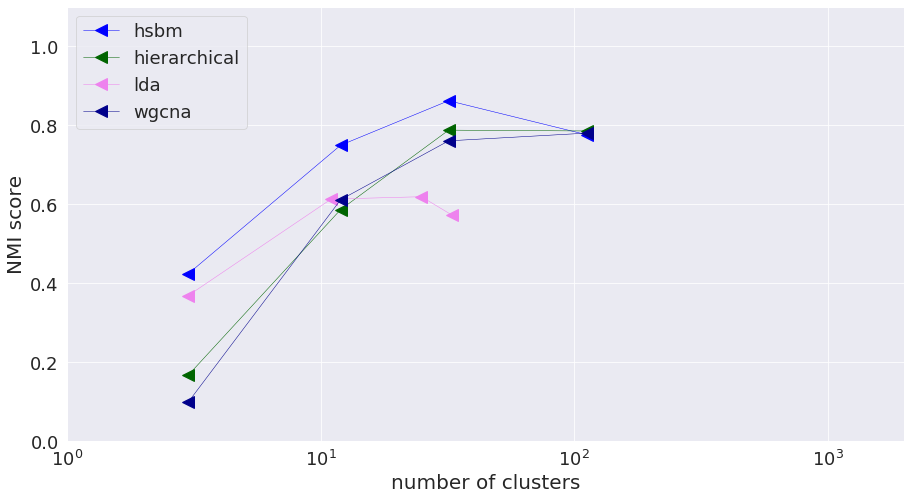

In [11]:
fig=plt.figure(figsize=(15,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,labels=['hsbm', 'tm', 'hierarchical', 'lda', 'wgcna', 'shuffle'])
plt.tick_params(labelsize=18)
#ax.set_xscale('linear')
plt.xlim(1,2000)
plt.legend(ncol=1, fontsize=18,loc='upper left' )
plt.show()
fig.savefig("%s/metric_scores_all.pdf"%(directory))

# Benchmark
https://scikit-learn.org/stable/modules/clustering.html

In [ ]:
true_labels = []
predicted_labels = []
for c in cluster:
    print(c)
    for sample in cluster[c]:
        #true_labels.append(getFile(sample)['primary_site'].values[0])
        try:
            true_labels.append(df_files.loc[sample][label])
            predicted_labels.append(c)
        except:
            print("error in %s"%sample)

In [ ]:
_, labels_true = np.unique(true_labels,return_inverse=True)

In [ ]:
series_metrics=pd.Series(name=setup+'__level_%d_%s'%(level,label))
series_metrics['MI']=metrics.cluster.normalized_mutual_info_score(labels_true, predicted_labels, average_method='arithmetic')
series_metrics['Homogeneity']=metrics.cluster.homogeneity_score(labels_true, predicted_labels) 
series_metrics['Completness']=metrics.cluster.completeness_score(labels_true, predicted_labels) 
series_metrics['Vmeasure']=metrics.cluster.v_measure_score(labels_true, predicted_labels)
series_metrics['Fowlkes-Mallows']=metrics.cluster.fowlkes_mallows_score(labels_true,predicted_labels)
series_metrics['AdjustedRandIndex']=metrics.cluster.adjusted_rand_score(labels_true,predicted_labels)

In [ ]:
series_metrics

In [ ]:
#df_metrics = pd.DataFrame(columns=['AdjustedRandIndex','MI','Homogeneity','Completness','Vmeasure','Fowlkes-Mallows'])

In [ ]:
try:
    df_metrics.append(series_metrics, ignore_index=False, verify_integrity=True).to_csv("results/hSBM/metrics.csv", index=True,header=True)
except:
    raise

In [ ]:
df_metrics = pd.read_csv("results/hSBM/metrics.csv", index_col=[0],header=[0])
df_metrics.sort_values(by=['MI','Homogeneity'], ascending=False, axis=0, inplace=True)
df_metrics.round(decimals=2)

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(24, 20)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = pd.plotting.table(ax, df_metrics.round(decimals=2), loc='upper right', colWidths=[0.12]*len(df_metrics.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1, 2) # change size table
plt.savefig('results/hSBM/metrics.pdf', transparent=True)

In [ ]:
metrics.cluster.contingency_matrix(true_labels, predicted_labels)

In [ ]:
df_files[df_files['primary_site']=='Brain']